This file is to test SGM model by pytorch (Mar 24, 2023) 

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
import torch
from easydict import EasyDict as edict
from spectrome import Brain

In [125]:
def network_transfer_local(C, D, parameters, w):
    """Network Transfer Function for spectral graph model for give freq w
    Args:
        brain (Brain): specific brain to calculate NTF
        parameters (dict): parameters for ntf. We shall keep this separate from Brain
        for now, as we want to change and update according to fitting.
        frequency (float): frequency at which to calculate NTF
    Returns:
        model_out (numpy asarray):  Each region's frequency response for
        the given frequency (w)
        frequency_response (numpy asarray):
        ev (numpy asarray): Eigen values
        Vv (numpy asarray): Eigen vectors
    """
    #C = brain.reducedConnectome
    #D = brain.distance_matrix

    
    parameters = np.asarray(parameters)
    tau_e = parameters[0]
    tau_i = parameters[1]
    tauC =  parameters[2]
    speed = parameters[3]
    alpha = parameters[4]
    gii =   parameters[5]  
    gei =   parameters[6]  
    gee = 1
    
    # Defining some other parameters used:
    zero_thr = 0.05

    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    nroi = C.shape[0]

    K = nroi

    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)

    # Eigen Decomposition of Complex Laplacian Here
    L1 = np.identity(nroi)
    L21 = np.divide(1, np.sqrt(rowdegree) + np.spacing(1))
    L22 = np.divide(1, np.sqrt(coldegree) + np.spacing(1))
    L = L1 - alpha * np.matmul(np.matmul(np.diag(L21), Cc), np.diag(L22))
    #L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    #L = L1 - alpha * np.matmul(np.diag(L2), Cc)

    d, v = np.linalg.eig(L)  
    v_inv = np.linalg.inv(v)
    eig_ind = np.argsort(np.abs(d))  # sorting in ascending order and absolute value
    eig_vec = v[:, eig_ind]  # re-indexing eigen vectors according to sorted index
    eig_val = d[eig_ind]  # re-indexing eigen values with same sorted index
    eig_vec_inv = v_inv[eig_ind, :]

    eigenvalues = np.transpose(eig_val)
    eigenvectors = eig_vec[:, 0:K]

#     # Cortical model
    Fe = np.divide(1 / tau_e ** 2, (1j * w + 1 / tau_e) ** 2)
    Fi = np.divide(1 / tau_i ** 2, (1j * w + 1 / tau_i) ** 2)
    FG = np.divide(1 / tauC ** 2, (1j * w + 1 / tauC) ** 2)

    Hed = (1 + (Fe * Fi * gei)/(tau_e * (1j * w + Fi * gii/tau_i)))/(1j * w + Fe * gee/tau_e + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fi * gii / tau_i)))
    
    Hid = (1 - (Fe * Fi * gei)/(tau_i * (1j * w + Fe * gee/tau_e)))/(1j * w + Fi * gii/tau_i + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fe * gee / tau_e)))

    Htotal = Hed + Hid


    # why this step
#     q1 = (1j * w + 1 / tau_e * Fe * eigenvalues)
    q1 = (1j * w + 1 / tauC * FG * eigenvalues)
    qthr = zero_thr * np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1), qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1, np.exp(1j * angq1))
    frequency_response = np.divide(Htotal, q1)
    
    model_out = 0

    for k in range(K):
        model_out += (frequency_response[k]) * np.outer(eigenvectors[:, k], eig_vec_inv[k, :]) 
        #model_out += (frequency_response[k]) * np.outer(eigenvectors[:, k], np.conjugate(eigenvectors[:, k])) 
    model_out2 = np.linalg.norm(model_out,axis=1)

    
    return model_out2, frequency_response, eigenvalues, eigenvectors, L


class SGM:
    def __init__(self, C, D, freqs, band="alpha"):
        self.freqs = freqs 
        self.C = C
        self.D = D
        if band == "alpha":
            self.freqband = np.where((freqs>=8) & (freqs<=12))[0]
        elif band == "beta":
            self.freqband = np.where((freqs>=13) & (freqs<=25))[0]
        else:
            self.freqband = np.arange(len(freqs))
            
    def run_local_coupling_forward(self, params):
        """run_forward. Function for running the forward model over the passed in range of frequencies,
        for the handed set of parameters (which must be passed in as a dictionary)
    
        Args:
            brain (Brain): An instance of the Brain class.
            #C = brain.reducedConnectome
            #D = brain.distance_matrix
            params (dict): Dictionary of a setting of parameters for the NTF model.
            freqs (array): Array of freqencies for which the model is to be calculated.
    
        Returns:
            array: Model values for each frequency, for each region of the brain, ordered as according to HCP
            (as in Brain class ordering).
    
        """
    
        eigenvalues = []
        eigenvectors = []
        frequency_response = []
        model_out = []
    
        for freq in self.freqs:
            w = 2 * np.pi * freq
            freq_model, freq_resp, eig_val, eig_vec = network_transfer_local(
                self.C, self.D, params, w
            )
            frequency_response.append(freq_resp)
            eigenvalues.append(eig_val)
            eigenvectors.append(eig_vec)
            model_out.append(freq_model)
    
        frequency_response = np.asarray(frequency_response)
        eigenvalues = np.asarray(eigenvalues)
        eigenvectors = np.asarray(eigenvectors)
        model_out = np.transpose(np.asarray(model_out))
        
        model_out_band = model_out[:68, self.freqband]
        #model_out_band_sum = np.sum(model_out_band,axis = 1)
        #model_out_band_sum_norm = model_out_band_sum/np.linalg.norm(model_out_band_sum) # spatial feature on the specific band
    
        return model_out,  model_out_band

In [180]:
def my_fn(C, D, parameters, w):
    parameters = np.asarray(parameters)
    tau_e = parameters[0]
    tau_i = parameters[1]
    tauC =  parameters[2]
    speed = parameters[3]
    alpha = parameters[4]
    gii =   parameters[5]  
    gei =   parameters[6]  
    gee = 1
    
    # Defining some other parameters used:
    zero_thr = 0.05

    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    nroi = C.shape[0]

    K = nroi

    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)
    Cc = np.triu(Cc) + np.tril(np.conj(Cc), -1)

    # Eigen Decomposition of Complex Laplacian Here
    L1 = np.identity(nroi)
    L21 = np.divide(1, np.sqrt(rowdegree) + np.spacing(1))
    L22 = np.divide(1, np.sqrt(coldegree) + np.spacing(1))
    L = L1 - alpha * np.matmul(np.matmul(np.diag(L21), Cc), np.diag(L22))
    #L1 = np.identity(nroi)
    #L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    #L = L1 - alpha * np.matmul(np.diag(L2), Cc)
    # L2 is to normalized via row-degree, 
    #!!! but I think we should do symmetric normalization

    # Cortical model
    Fe = np.divide(1 / tau_e ** 2, (1j * w + 1 / tau_e) ** 2)
    Fi = np.divide(1 / tau_i ** 2, (1j * w + 1 / tau_i) ** 2)
    FG = np.divide(1 / tauC ** 2, (1j * w + 1 / tauC) ** 2)

    Hed = (1 + (Fe * Fi * gei)/(tau_e * (1j * w + Fi * gii/tau_i)))/(1j * w + Fe * gee/tau_e + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fi * gii / tau_i)))
    
    Hid = (1 - (Fe * Fi * gei)/(tau_i * (1j * w + Fe * gee/tau_e)))/(1j * w + Fi * gii/tau_i + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fe * gee / tau_e)))

    Htotal = Hed + Hid


    left_mat = 1j * w + L*FG/tauC
    model_out = np.linalg.inv(left_mat) * Htotal
    model_out2 = np.linalg.norm(model_out, axis=1)
    return model_out2, left_mat, L, C * np.exp(-1j * Tau * w)

In [5]:
paras = edict()
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]


In [6]:
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [7]:
#parameters = paras.par_high
parameters = np.array([0.0147, 0.0151, 0.009, 3.05, 1, 8.37, 0.5])
C = brain.reducedConnectome
D = brain.distance_matrix
w = 2 * np.pi * 10

In [184]:
_, _, tt, Cc = my_fn(C, D, parameters, w)

In [185]:
Cc1 = np.triu(Cc) + np.tril(np.conj(Cc), -1)

<AxesSubplot:>

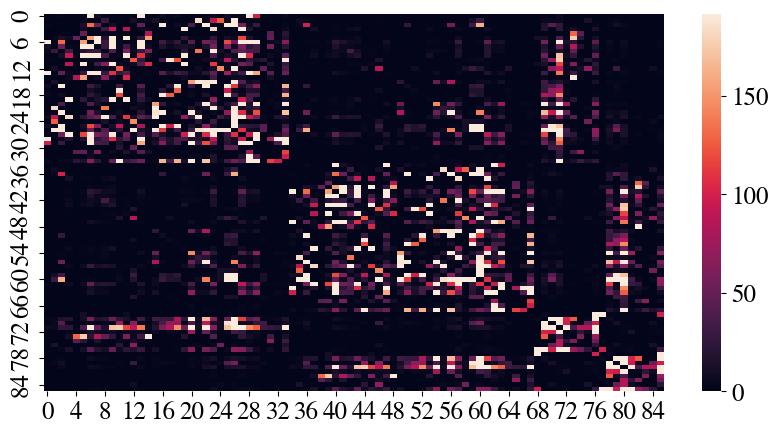

In [189]:
sns.heatmap(np.abs(Cc1))

In [175]:
res = np.linalg.eig(tt)
mat = res[1]
tt_mat = mat @ np.matrix.getH(mat)

In [176]:
tmat = np.random.randn(3, 3)

array([[0.        , 0.        , 0.        ],
       [1.23661701, 0.        , 0.        ],
       [0.46261788, 2.09945744, 0.        ]])

In [190]:
np.triu(tmat) 

array([[-1.01702177,  1.12126606,  0.07072395],
       [ 0.        , -0.42346864,  0.92769053],
       [ 0.        ,  0.        , -0.89064619]])

In [152]:
_, _, _, _, tt = network_transfer_local(C, D, parameters, w)

In [158]:
np.abs(np.abs(tt @ np.matrix.getH(tt))-1).max()

0.9999954641612686

<AxesSubplot:>

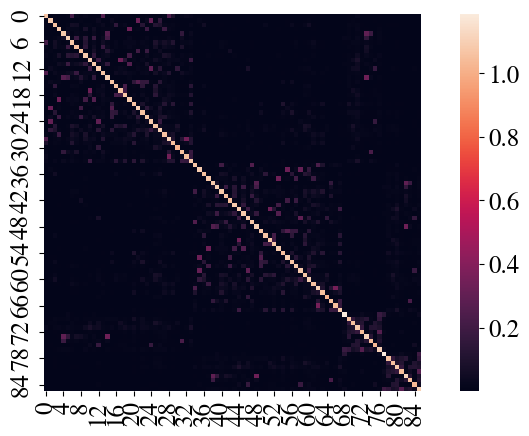

In [153]:
sns.heatmap(np.abs(tt @ np.matrix.getH(tt)), square=True)

<AxesSubplot:>

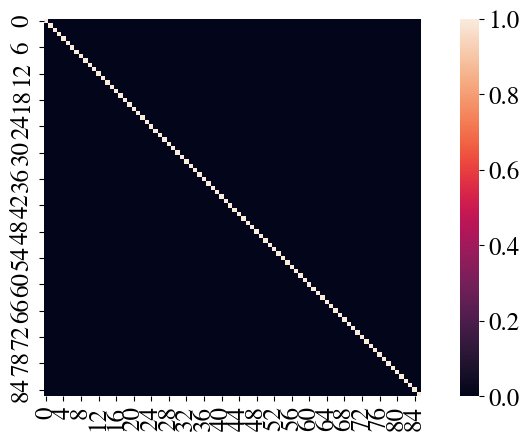

In [154]:
sns.heatmap(np.abs(tt @ np.linalg.inv(tt)), square=True)

In [140]:
res[1][:4, :4]

array([[ 0.09044876+0.02694684j, -0.1125199 -0.0025198j ,
         0.02693575-0.07737691j, -0.02501067-0.01382205j],
       [ 0.06966775+0.05796902j, -0.05554663-0.01658162j,
        -0.0445898 +0.04190558j, -0.00646065-0.01999822j],
       [ 0.1008751 -0.03734704j, -0.04918642+0.0116689j ,
        -0.05422887+0.06642444j, -0.03401334+0.00466412j],
       [ 0.08124805+0.04918408j, -0.10082846-0.03792614j,
         0.10431306-0.05694663j, -0.00851218-0.00453086j]])

In [141]:
np.matrix.getH(res[1])[:4, :4]

array([[ 0.09044876-0.02694684j,  0.06966775-0.05796902j,
         0.1008751 +0.03734704j,  0.08124805-0.04918408j],
       [-0.1125199 +0.0025198j , -0.05554663+0.01658162j,
        -0.04918642-0.0116689j , -0.10082846+0.03792614j],
       [ 0.02693575+0.07737691j, -0.0445898 -0.04190558j,
        -0.05422887-0.06642444j,  0.10431306+0.05694663j],
       [-0.02501067+0.01382205j, -0.00646065+0.01999822j,
        -0.03401334-0.00466412j, -0.00851218+0.00453086j]])

In [138]:
res = np.linalg.eig(tt)
tt1 = res[1] @ np.diag(res[0]) @ np.linalg.inv(res[1])
tt2 = res[1] @ np.diag(res[0]) @ np.matrix.getH(res[1])

In [139]:
print(np.linalg.norm(tt.T - tt), 
np.linalg.norm(tt1 - tt), 
np.linalg.norm(tt2 - tt))

6.492020766738879e-16 4.4415077968011846e-14 10.483471698544879


In [120]:
tt1s = []
tt2s = []
for f in np.linspace(2, 45, 40):
    w = np.pi * 2 * f
    tt1, _, _, _ = network_transfer_local(C, D, parameters, w)
    tt2 = my_fn(C, D, parameters, w)
    tt1s.append(tt1)
    tt2s.append(tt2)

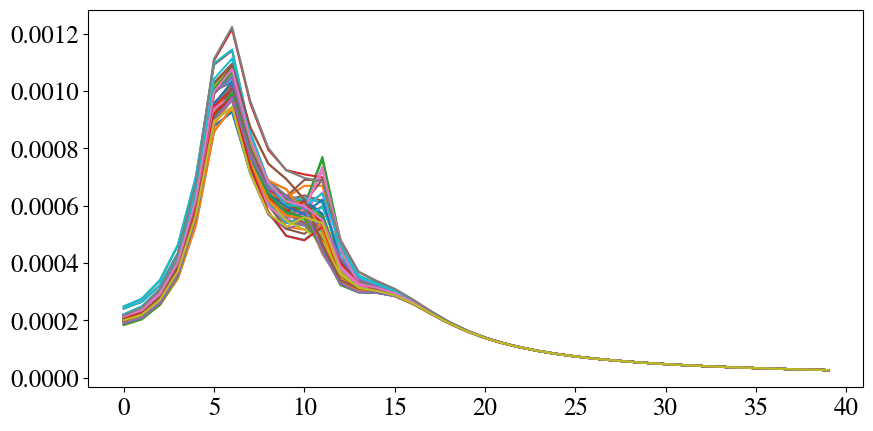

In [121]:
tts = np.array(tt1s)
plt.plot(tts[:, :68].mean(axis=1))
for ix in range(68):
    plt.plot(tts[:, ix])

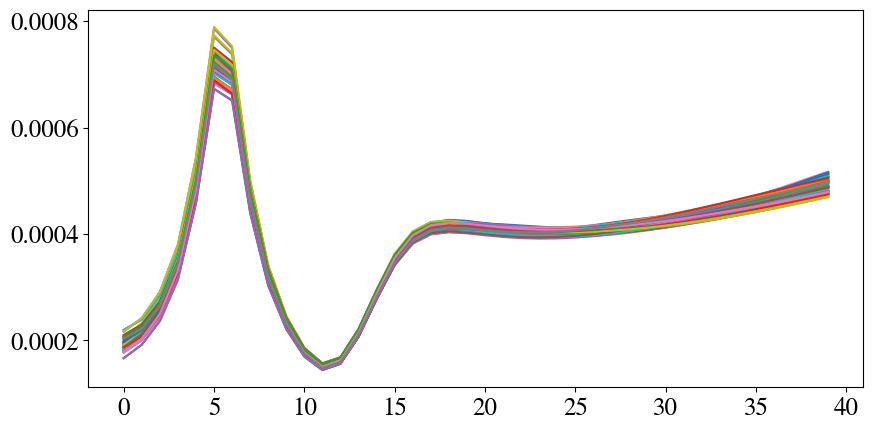

In [84]:
tts = np.array(tt2s)
for ix in range(68):
    plt.plot(tts[:, ix])
    #plt.plot(tts[:, :68].mean(axis=1))